Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import sys
import time

import numpy as np
import pandas as pd
import scipy as sc
import sklearn
from scipy import stats as st
import statsmodels.stats.api as sms
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool


/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.7/imp.py:342: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return _load(spec)
/opt/conda/lib/python3.7/site-packages/ipywidgets/widgets/widget_selection.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Iterable


In [3]:
from pprint import pprint
from IPython.display import Markdown, display, display_html, HTML

def printmd(string, color=None):
    if color != None:
        string = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(string))    

def print_bold(string, color=None):
    printmd("**{}**".format(string), color)

def print_header(string):
    printmd("### {}".format(string))

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin-right: 10px;"'),raw=True)

def print_df(df):
    display_side_by_side(df)
    
# printmd('__bold__')
# print_bold('bold')
# print_header('print_header')

In [4]:
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

def _sizeof_fmt(elem):
    elem = list(elem)
    elem[1] = sizeof_fmt(elem[1])
    return elem


def print_mem_usage_vars(_dir):
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    mem_usage = [(x, sys.getsizeof(globals().get(x))) for x in _dir if not x.startswith('_') and x not in sys.modules and x not in ipython_vars]
    mem_usage = sorted(mem_usage, key=lambda x: x[1], reverse=True)

    pprint(list(map(_sizeof_fmt, mem_usage[:10])))

# print_mem_usage_vars(dir())

In [5]:
data = pd.read_csv('/datasets/autos.csv')

In [6]:
data.shape

(354369, 16)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [8]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [9]:
print(data.columns, 'len:', len(data.columns))

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object') len: 16


In [10]:
# Упорядочить колонки по значимости
cols_sorted = [
    'Brand', 'Model', 'RegistrationYear', 'RegistrationMonth', 'Power', 'Gearbox', 'FuelType', 'VehicleType',
    'Kilometer', 'NotRepaired', 'Price',  
    'NumberOfPictures', 'PostalCode',
    'DateCrawled', 'DateCreated', 'LastSeen'
]
len(cols_sorted)

16

In [11]:
data = data[cols_sorted]

In [12]:
cols_duplicated = [col for col in cols_sorted if col not in ['DateCrawled', 'DateCreated', 'LastSeen']]

In [13]:
data.duplicated(subset=cols_duplicated).sum()

21333

In [14]:
data.duplicated(subset=cols_duplicated, keep=False).sum()

39045

In [15]:
data[data.duplicated(subset=cols_duplicated, keep=False)].sort_values(by=cols_duplicated).head(4)

,Brand,Model,RegistrationYear,RegistrationMonth,Power,Gearbox,FuelType,VehicleType,Kilometer,NotRepaired,Price,NumberOfPictures,PostalCode,DateCrawled,DateCreated,LastSeen
68907,alfa_romeo,145,2000,12,103,manual,petrol,small,90000,no,2200,0,86368,2016-04-03 15:48:43,2016-04-03 00:00:00,2016-04-03 15:48:43
83966,alfa_romeo,145,2000,12,103,manual,petrol,small,90000,no,2200,0,86368,2016-04-03 15:54:45,2016-04-03 00:00:00,2016-04-03 15:54:45
39759,alfa_romeo,147,2001,1,150,manual,petrol,coupe,150000,no,2100,0,37077,2016-03-17 22:53:33,2016-03-17 00:00:00,2016-03-21 06:17:09
224333,alfa_romeo,147,2001,1,150,manual,petrol,coupe,150000,no,2100,0,37077,2016-03-21 13:50:56,2016-03-21 00:00:00,2016-03-21 13:50:56


In [16]:
# Колонки по типам данных
cols_date = ['DateCrawled', 'DateCreated', 'LastSeen']
cols_numeric = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
cols_category = [col for col in data.columns if col not in cols_numeric and col not in cols_date]
cols_category

['Brand',
 'Model',
 'RegistrationMonth',
 'Gearbox',
 'FuelType',
 'VehicleType',
 'NotRepaired',
 'NumberOfPictures',
 'PostalCode']

## Выводы

Колонки содержащие пустые значениия

* Model                19705
* Gearbox              19833
* FuelType             32895
* VehicleType          37490
* NotRepaired          71154


Полных дублей - 21333.<br>
Полные дубли это сроки содержание одинаковы значения во всех колонках кроме: DateCrawled, DateCreated, LastSeen


NA значения

* Model - (всего: 334664, na: 19705 (5.89%))
* Gearbox - (всего: 334536, na: 19833 (5.93%))
* FuelType - (всего: 321474, na: 32895 (10.23%))
* VehicleType - (всего: 316879, na: 37490 (11.83%))
* NotRepaired - (всего: 283215, na: 71154 (25.12%))


Типы данных в порядке. Колонки DateCrawled, DateCreated, LastSeen я не использую, поэтому не привожу их к типу дата.


## Анализ данных

In [17]:
# Гистгорама и Диаграмма размаха
def data_explore(data_df, col, title, whis=1.5):
    query = data_df[[col]]
    # query = data_df.groupby(['user_id', 'month'])
    # if sum_col == None:
    #    query = query.count()[['id']]
    # else:
    #     query = query[[sum_col]].sum()
        
    query.plot(kind='hist', title=title)
    plt.show()
    # query.boxplot(whis=2, figsize=(8,6))
    query.boxplot(whis=1.5)
    plt.show()


In [18]:
def print_droped_analize2(title, cnt_total, cnt_selected_to_drop, cnt_keeped_afted_drop):
    cnt_dropped_total = cnt_total - cnt_keeped_afted_drop
    proc_dropped_total = round(cnt_dropped_total*100/cnt_total,1)
    proc_selected_to_drop = round(cnt_selected_to_drop*100/cnt_total,1)
    
    print('{}. всего: {}, к удалению {} ({}%), сохранено: {}, удалено всего: {} ({}%)'.format(
        title, 
        cnt_total, 
        cnt_selected_to_drop, 
        proc_selected_to_drop,
        cnt_keeped_afted_drop,
        cnt_dropped_total, 
        proc_dropped_total
    ))

# print_droped_analize2(title='test', cnt_total=10000, cnt_selected_to_drop=120, cnt_keeped_afted_drop=8347)

In [19]:
# Анализ выбросов
def print_droped_analize(title, total, last):
    droped = total - last
    proc = round(droped * 100 / total,1)
    print('{}. всего: {}, осталось: {}, удалено: {} ({}%)'.format(title, total, last, droped, proc))

def print_discharge_query(df, col, whis=1.5):
    lh = {}
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    lov = round(df[col].quantile(0.25) - whis * IQR, 2)
    hei = round(df[col].quantile(0.75) + whis * IQR, 2)
    lh[col] = (lov, hei)

    query_good = '({} >= {} and {} <= {})'.format(
        col,
        lh[col][0],
        col,
        lh[col][1]
    )

    print('query: {}'.format(query_good))

    # query1 = (df[col] < lh[col][0])
    # query2 = (df[col] > lh[col][1])
    # indexes = df[query1 | query2].index.values
    
    total = df.shape[0]
    saved = df.query(query_good).shape[0]
    print_droped_analize(col, total, saved)


In [20]:
def print_droped_query_save(df, query_save):
    total = df.shape[0]
    deleted = total - df[query_save].shape[0]
    proc = round((deleted / total) * 100, 2)
    print('Строк всего {}, удалено {} ({}%)'.format(
        total,
        deleted,
        proc
    ))

In [21]:
def print_col_with_na(data, verbose=True):
    print_header('Анализ колонок содержащих пустые значения')
    na = data.isna().sum()
    for col in na[na > 0].index:
        df = data[col].value_counts().to_frame()

        cnt_total = df.sum()[col]
        cnt_na = data.isna().sum()[col]
        prc_na = round((cnt_na / cnt_total) * 100,2)

        df_na = pd.DataFrame([{col:cnt_na}], index = ['n/a'])
        df = pd.concat([df, df_na]).sort_values(by=col, ascending=False)
        df = df.head(20)

        print_bold('{} - (всего: {}, na: {} ({}%))'.format(
            col, 
            cnt_total,
            cnt_na,
            prc_na
        ))
        
        if verbose:
            display_side_by_side(df)

    #     if col == 'Model':
    #         df.plot.barh(y=col, use_index=True)
    #     else:
    #         df.plot.bar(y=col, use_index=True)

            print()
        
# print_col_with_na(data, verbose=False)

In [22]:
data_notna = data.copy()

In [23]:
print_col_with_na(data, verbose=False)

### Анализ колонок содержащих пустые значения

**Model - (всего: 334664, na: 19705 (5.89%))**

**Gearbox - (всего: 334536, na: 19833 (5.93%))**

**FuelType - (всего: 321474, na: 32895 (10.23%))**

**VehicleType - (всего: 316879, na: 37490 (11.83%))**

**NotRepaired - (всего: 283215, na: 71154 (25.12%))**

In [24]:
data_notna = data_notna.drop_duplicates(subset=cols_duplicated)

print_droped_analize2(
    title='Удаление дубликатов', 
    cnt_total=data.shape[0], 
    cnt_selected_to_drop=data[data.duplicated(subset=cols_duplicated)].shape[0], 
    cnt_keeped_afted_drop=data_notna.shape[0]
)


Удаление дубликатов. всего: 354369, к удалению 21333 (6.0%), сохранено: 333036, удалено всего: 21333 (6.0%)


In [25]:
query_to_drop = '(Model.isna() and VehicleType.isna() and Gearbox.isna() and FuelType.isna())'
data_notna = data_notna.query('not (' + query_to_drop + ')')

print_droped_analize2(
    title='Удаление строк содержащих NA почти во всех полях', 
    cnt_total=data.shape[0], 
    cnt_selected_to_drop=data.query(query_to_drop).shape[0], 
    cnt_keeped_afted_drop=data_notna.shape[0]
)


Удаление строк содержащих NA почти во всех полях. всего: 354369, к удалению 2392 (0.7%), сохранено: 330763, удалено всего: 23606 (6.7%)


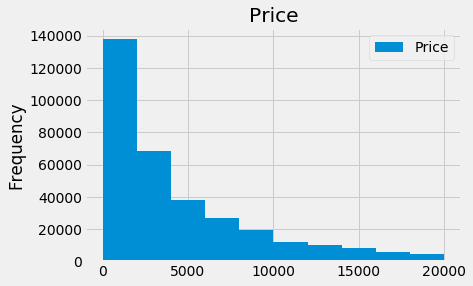

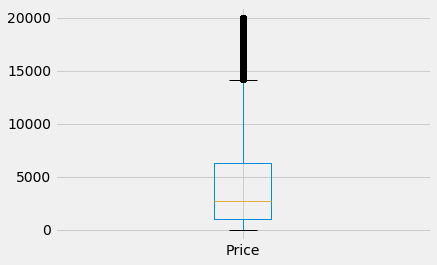

query: (Price >= -6825.0 and Price <= 14175.0)
Price. всего: 330763, осталось: 312485, удалено: 18278 (5.5%)


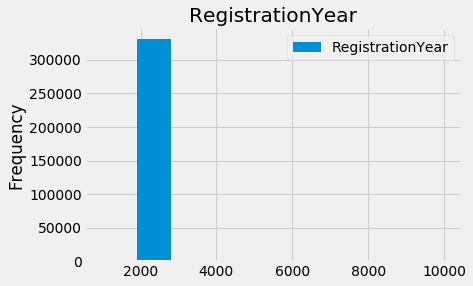

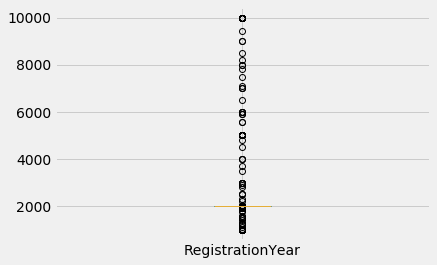

query: (RegistrationYear >= 1985.5 and RegistrationYear <= 2021.5)
RegistrationYear. всего: 330763, осталось: 324963, удалено: 5800 (1.8%)


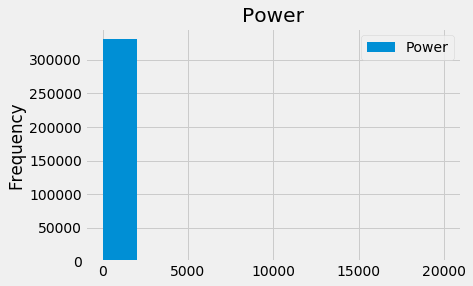

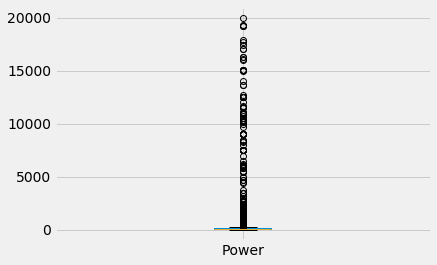

query: (Power >= -39.0 and Power <= 249.0)
Power. всего: 330763, осталось: 323096, удалено: 7667 (2.3%)


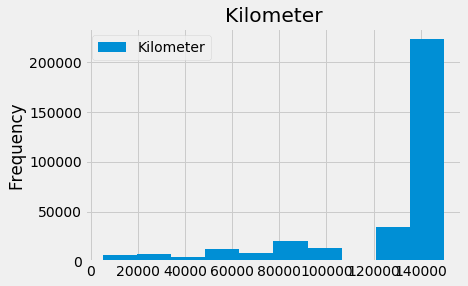

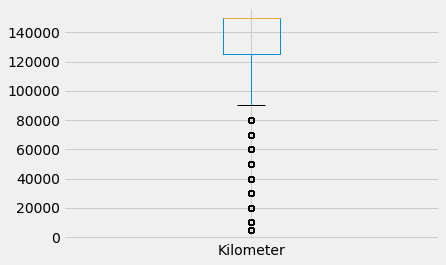

query: (Kilometer >= 87500.0 and Kilometer <= 187500.0)
Kilometer. всего: 330763, осталось: 281825, удалено: 48938 (14.8%)


In [26]:
for col in cols_numeric:
    data_explore(data_notna, col, col, whis=1.5)
    print_discharge_query(data_notna, col, whis=1.5)

In [27]:
query_to_drop = '(Price <= 0)'
data_notna = data_notna.query('not (' + query_to_drop + ')')

print_droped_analize2(
    title=query_to_drop, 
    cnt_total=data.shape[0], 
    cnt_selected_to_drop=data.query(query_to_drop).shape[0], 
    cnt_keeped_afted_drop=data_notna.shape[0]
)


(Price <= 0). всего: 354369, к удалению 10772 (3.0%), сохранено: 321462, удалено всего: 32907 (9.3%)


In [28]:
printmd('Записей с регистрацией после 2020 года: **{}**, записей до 1950: **{}**'.format(
    data.query('RegistrationYear > 2020').shape[0],
    data.query('RegistrationYear < 1950 and RegistrationYear not in (1000, 1910)').shape[0],
))

Записей с регистрацией после 2020 года: **105**, записей до 1950: **108**

In [29]:
# data_notna.loc[data_notna.query('RegistrationYear == 1910').index, 'RegistrationYear'] = 2010
# data_notna.loc[data_notna.query('RegistrationYear == 1000').index, 'RegistrationYear'] = 2000

In [30]:
query_to_drop = '(RegistrationYear < 1950 or RegistrationYear > 2020)'
data_notna = data_notna.query('not (' + query_to_drop + ')')

print_droped_analize2(
    title=query_to_drop, 
    cnt_total=data.shape[0], 
    cnt_selected_to_drop=data.query(query_to_drop).shape[0], 
    cnt_keeped_afted_drop=data_notna.shape[0]
)


(RegistrationYear < 1950 or RegistrationYear > 2020). всего: 354369, к удалению 351 (0.1%), сохранено: 321261, удалено всего: 33108 (9.3%)


## Признак Power

In [31]:
# data_notna.query('(Power <= 0)')['Power'].value_counts()
printmd('Кол-во записей с Power <= 0: **{}**. Возможно их можно будет удалить на этапе отбора фич. Мне кажется это важная информация для цены, может быть даже важнее модели.'.format(
    data_notna.query('(Power <= 0)').shape[0]
))


Кол-во записей с Power <= 0: **33521**. Возможно их можно будет удалить на этапе отбора фич. Мне кажется это важная информация для цены, может быть даже важнее модели.

In [32]:
data_notna.query('Power>1000')['Power'].value_counts()


1598     7
1001     6
1800     6
1500     4
1400     4
        ..
13636    1
1339     1
9013     1
9011     1
1024     1
Name: Power, Length: 213, dtype: int64

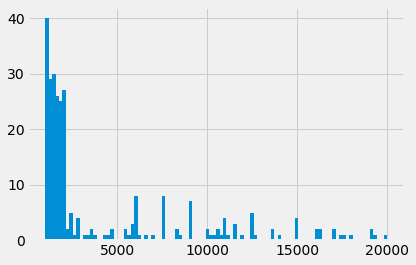

In [33]:
data_notna.query('Power>1000')['Power'].hist(bins=100)

In [34]:
query_to_drop = '(Power == 0)'
data_notna = data_notna.query('not (' + query_to_drop + ')')

print_droped_analize2(
    title=query_to_drop, 
    cnt_total=data.shape[0], 
    cnt_selected_to_drop=data.query(query_to_drop).shape[0], 
    cnt_keeped_afted_drop=data_notna.shape[0]
)


(Power == 0). всего: 354369, к удалению 40225 (11.4%), сохранено: 287740, удалено всего: 66629 (18.8%)


In [35]:
query_to_drop = '(Power > 2000)'
data_notna = data_notna.query('not (' + query_to_drop + ')')

print_droped_analize2(
    title=query_to_drop, 
    cnt_total=data.shape[0], 
    cnt_selected_to_drop=data.query(query_to_drop).shape[0], 
    cnt_keeped_afted_drop=data_notna.shape[0]
)


(Power > 2000). всего: 354369, к удалению 120 (0.0%), сохранено: 287629, удалено всего: 66740 (18.8%)


In [36]:
# print_col_with_na(data, verbose=True)

## Обработка пропущенных значений

In [37]:
print_col_with_na(data_notna, verbose=False)

### Анализ колонок содержащих пустые значения

**Model - (всего: 275802, na: 11827 (4.29%))**

**Gearbox - (всего: 281904, na: 5725 (2.03%))**

**FuelType - (всего: 268555, na: 19074 (7.1%))**

**VehicleType - (всего: 267241, na: 20388 (7.63%))**

**NotRepaired - (всего: 242573, na: 45056 (18.57%))**

In [38]:
cols_to_unknown =  ['Model', 'Gearbox', 'FuelType', 'VehicleType', 'NotRepaired']
', '.join(cols_to_unknown)

'Model, Gearbox, FuelType, VehicleType, NotRepaired'

In [39]:
for col in cols_to_unknown:
    data_notna.loc[data_notna.query(col+'.isna()').index, col] = 'unknown'

In [40]:
print('Не указан Model: {}, не указан VehicleType {}, не указано оба признака {}'.format(
    data_notna.query('Model == "unknown"').shape[0],
    data_notna.query('VehicleType == "unknown"').shape[0],
    data_notna.query('Model == "unknown" and VehicleType == "unknown"').shape[0]
))

Не указан Model: 11827, не указан VehicleType 20388, не указано оба признака 2567


In [41]:
print_droped_analize2(
    title='Доступно для анализа', 
    cnt_total=data.shape[0], 
    cnt_selected_to_drop=0, 
    cnt_keeped_afted_drop=data_notna.shape[0]
)


Доступно для анализа. всего: 354369, к удалению 0 (0.0%), сохранено: 287629, удалено всего: 66740 (18.8%)


### Выводы

Удаление дубликатов. всего: 354369, к удалению 21333 (6.0%), сохранено: 333036, удалено всего: 21333 (6.0%)

Удаление строк содержащих NA почти во всех полях. всего: 354369, к удалению 2392 (0.7%), сохранено: 330763, удалено всего: 23606 (6.7%)

(Price <= 0). всего: 354369, к удалению 10772 (3.0%), сохранено: 321462, удалено всего: 32907 (9.3%)
		  
Записей с регистрацией после 2020 года: 105, записей до 1950: 108 - теми которые после 2020 можно повозиться еще, там года 00, скорее всего 2000 год. Записи с годами 1910 и 1000 спасены.

Кол-во записей с Power <= 0: 33561. Возможно их можно будет удалить на этапе отбора фич. Мне кажется это важная информация для цены, может быть даже важнее модели.

По Kilometer выбросов нет.

Для колонок Model, Gearbox, FuelType, VehicleType, NotRepaired NA значениям присвоено NA.

Доступно для анализа. всего: 354369, сохранено: 321313, удалено всего: 33056 (9.3%)



# 2. Обучение моделей

## Отбор признаков

In [42]:
cols_corr = ['RegistrationYear', 'Power', 'Kilometer', 'Price']
print_header('Корреляция')
df = data_notna[cols_corr].corr()
print_df(df.loc[:, 'Price'].to_frame())

### Корреляция

,Price
RegistrationYear,0.420040
Power,0.420293
Kilometer,-0.380836
Price,1.000000


In [43]:
data_notna.columns

Index(['Brand', 'Model', 'RegistrationYear', 'RegistrationMonth', 'Power',
       'Gearbox', 'FuelType', 'VehicleType', 'Kilometer', 'NotRepaired',
       'Price', 'NumberOfPictures', 'PostalCode', 'DateCrawled', 'DateCreated',
       'LastSeen'],
      dtype='object')

In [44]:
QqK4J939ztzzZL7cols_feature = [
    'Brand', 'Model', 'RegistrationYear', 'Power',
    'Gearbox', 'FuelType', 'VehicleType', 'Kilometer', 'NotRepaired'
]

cols_cat = [
    'Brand', 'Model', 'Gearbox', 'FuelType', 'VehicleType', 'NotRepaired'
]

cols_cat_idx = [cols_feature.index(col) for col in cols_cat]

### Подготовка данных для деревьев и лесов

In [45]:
data_train = data_notna[cols_feature + ['Price']].copy()

encoder = OrdinalEncoder()
data_train[cols_cat] = encoder.fit_transform(data_train[cols_cat])

data_train_smp1k = data_train.sample(1000, random_state=42)
data_train_smp10k = data_train.sample(10000, random_state=42)
data_train_smp100k = data_train.sample(100000, random_state=42)

# X = data_train_smp10k[cols_feature].values
# y = data_train_smp10k['Price'].values

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size = 0.25, random_state = 42
# )

In [46]:
%%time

X = data_train_smp10k[cols_feature]
y = data_train_smp10k['Price']

model = RandomForestRegressor(n_estimators=20, random_state=42)
model.fit(X, y)


CPU times: user 648 ms, sys: 0 ns, total: 648 ms
Wall time: 655 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [47]:
feature_list = list(X.columns)


In [48]:
importances = list(model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: RegistrationYear     Importance: 0.47
Variable: Power                Importance: 0.3
Variable: Kilometer            Importance: 0.08
Variable: Brand                Importance: 0.04
Variable: Model                Importance: 0.04
Variable: VehicleType          Importance: 0.04
Variable: NotRepaired          Importance: 0.02
Variable: Gearbox              Importance: 0.01
Variable: FuelType             Importance: 0.01


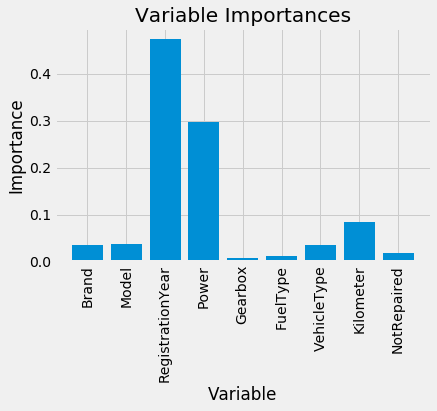

In [49]:
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [50]:
print('При том что признак Power так важен, {} записей со значением 0'.format(
    data_train.query('Power == 0').shape[0]
))

При том что признак Power так важен, 0 записей со значением 0


## Обучение

In [51]:
def rmse(y_test, y_pred):
    return (mean_squared_error(y_test, y_pred) ** 0.5)

def print_score_cmp(title, y_train, y_train_pred, y_test, y_test_pred):
    rmse_train = print_score(title + ' train', y_train, y_train_pred)
    rmse_test = print_score(title + ' test', y_test, y_test_pred)
    return rmse_train, rmse_test

def print_score(title, y_test, y_pred):
    errors = abs(y_pred - y_test)
    _rmse = rmse(y_test, y_pred)
    print(title, 'Average error: ', round(np.mean(errors), 2))
    print(title, 'RMSE:', _rmse)
    return _rmse

def mape(y_true, y_pred): 
    #     y_true, y_pred = check_arrays(y_true, y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# print_score('test', np.array([100]), np.array([99]))
# print_score('test', np.array([100]), np.array([99]))

# print_score_cmp('test', np.array([100]), np.array([99]),np.array([100]), np.array([99]))

In [52]:
df_result = pd.DataFrame(columns=['nick', 'rmse_train', 'rmse_test', 'time'])

def df_result_add(df_result, nick, rmse_train, rmse_test, time):
    return df_result.append(
        {'nick': nick, 'rmse_train': rmse_train, 'rmse_test': rmse_test, 'time': time}, 
        ignore_index=True
    )

## Baseline

In [53]:
X = data_train[cols_feature]
y = data_train['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42
)

In [54]:
train_preds = np.full(y_train.size, np.mean(y))
test_preds = np.full(y_test.size, np.mean(y))
rmse_train, rmse_test = print_score_cmp('Baseline', y_train, train_preds, y_test, test_preds)
df_result = df_result_add(df_result, 'Baseline', rmse_train, rmse_test, 0)
df_result

Baseline train Average error:  3600.02
Baseline train RMSE: 4571.545490281787
Baseline test Average error:  3616.89
Baseline test RMSE: 4594.845323742783


,nick,rmse_train,rmse_test,time
0,Baseline,4571.54549,4594.845324,0


## LinearRegression

In [55]:
%%time

t0 = time.time()

data_train_ohe = data_notna[cols_feature + ['Price']].copy()
data_train_ohe = pd.get_dummies(data_train_ohe, columns=cols_cat, drop_first=True)
data_train_ohe.columns


cols_feature_ohe = [col for col in data_train_ohe.columns if col != 'Price']
X = data_train_ohe[cols_feature_ohe]
y = data_train_ohe['Price']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

# print_score('LinearRegression', y_test, y_pred)
rmse_train, rmse_test = print_score_cmp('LinearRegression', y_train, y_pred_train, y_test, y_pred)

df_result = df_result_add(df_result, 'LinearRegression', rmse_train, rmse_test, (time.time() - t0))
df_result

LinearRegression train Average error:  1851.31
LinearRegression train RMSE: 2692.1582685668614
LinearRegression test Average error:  1863.16
LinearRegression test RMSE: 2709.0635119003337
CPU times: user 22.7 s, sys: 7.59 s, total: 30.2 s
Wall time: 30.2 s


,nick,rmse_train,rmse_test,time
0,Baseline,4571.545490,4594.845324,0
1,LinearRegression,2692.158269,2709.063512,30.1797


### Удаление неиспользуемых переменных

In [56]:
print_mem_usage_vars(dir())

[['X', '680.3MiB'],
 ['X_train', '510.2MiB'],
 ['data', '217.0MiB'],
 ['data_notna', '195.8MiB'],
 ['X_test', '170.1MiB'],
 ['data_train_ohe', '95.2MiB'],
 ['data_train', '24.1MiB'],
 ['data_train_smp100k', '8.4MiB'],
 ['y', '4.4MiB'],
 ['y_train', '3.3MiB']]


In [57]:
del data_notna 
del data
del X
del X_train
del X_test
del data_train_ohe

# print_mem_usage_vars(dir())

### RandomForestRegressor

#### RandomForestRegressor  подбор параметров

In [58]:
# n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print('random_grid')
# pprint(random_grid)
# print()


n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 3)]
# max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
}
print('param_grid')
pprint(param_grid)
print()

param_grid
{'max_depth': [10, 60, 110, None], 'n_estimators': [50, 275, 500]}



In [59]:
def rmse_scorer(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    print('RMSE: {}'.format(rmse))
    return rmse
# rmse_scorer(y_test, y_pred)

def my_scorer():
    return make_scorer(rmse_scorer, greater_is_better=False) 


In [60]:
%%time

X = data_train_smp10k[cols_feature]
y = data_train_smp10k['Price']

rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(
#     estimator = rf, 
#     param_distributions = random_grid, 
#     n_iter = 100,
#     cv = 3, 
#     verbose=2, 
#     random_state=42, 
#     n_jobs = -1
# )
# rf_random.fit(X, y)
# rf_random.best_params_
# del rf_random

grid_search = GridSearchCV(
    estimator = rf, 
    param_grid = param_grid, 
    cv = 3, 
    n_jobs = -1, 
    verbose = 2,
    scoring=my_scorer()
)
# grid_search.fit(X, y)
# grid_search.best_params_


CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 7.42 ms


#### Обучение модели

In [61]:
X = data_train_smp100k[cols_feature].values
y = data_train_smp100k['Price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42
)


In [62]:
%%time

t0 = time.time()

# params = grid_search.best_params_
params = {'max_depth': 110, 'n_estimators': 500}

model = RandomForestRegressor(**params)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)
rmse_train, rmse_test = print_score_cmp('RandomForestRegressor', y_train, y_pred_train, y_test, y_pred)
df_result = df_result_add(df_result, 'RandomForestRegressor', rmse_train, rmse_test, (time.time() - t0))
df_result

RandomForestRegressor train Average error:  549.49
RandomForestRegressor train RMSE: 887.6540617324404
RandomForestRegressor test Average error:  1096.52
RandomForestRegressor test RMSE: 1777.1887673794745
CPU times: user 2min 11s, sys: 1.23 s, total: 2min 12s
Wall time: 2min 12s


,nick,rmse_train,rmse_test,time
0,Baseline,4571.545490,4594.845324,0
1,LinearRegression,2692.158269,2709.063512,30.1797
2,RandomForestRegressor,887.654062,1777.188767,132.707


### LightGBM

In [63]:
def rmse_lgb(y_true, y_pred):
    score = mean_squared_error(y_true, y_pred)**0.5
    return ('RMSE', score, False)

#### Подбор гиперпараметров 

In [64]:
X = data_train_smp10k[cols_feature].values
y = data_train_smp10k['Price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42
)


In [65]:
estimator = lgb.LGBMRegressor()


# # __Stop
# n_estimators = [int(x) for x in np.linspace(100, 5000, num = 3)]
# max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
# max_depth.append(None)


# param_grid = {
#     'learning_rate': [0.01, 0.05],
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
# #     'num_leaves': [5, 10, 20],
# #     'min_data': [25, 50, 100],
# }


param_grid = {
    'learning_rate': [0.005],
    'n_estimators': [20,100,300],
    'max_depth': [-1,20,50],
}

pprint(param_grid)


{'learning_rate': [0.005],
 'max_depth': [-1, 20, 50],
 'n_estimators': [20, 100, 300]}


In [66]:
%%time

gbm = GridSearchCV(
    estimator, 
    param_grid, 
    cv=3,
    verbose=2, 
    n_jobs = -1,
    scoring=my_scorer()

)

# gbm.fit(
#     X_train, 
#     y_train, 
#     eval_metric=rmse_lgb,
#     categorical_feature=cols_cat_idx,
# )
# print('Best parameters found by grid search are:', gbm.best_params_)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 45.8 µs


In [67]:
# print(gbm.best_params_)
# print(gbm.best_score_)

# Best parameters found by grid search are: {'learning_rate': 0.005, 'max_depth': -1, 'n_estimators': 300}
# CPU times: user 45.2 s, sys: 704 ms, total: 45.9 s
# Wall time: 46.5 s

#### Обучение

In [68]:
X = data_train[cols_feature].values
y = data_train['Price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42
)


In [69]:
%%time

t0 = time.time()

params = {'learning_rate': 0.005, 'max_depth': -1, 'n_estimators': 300}


# train
model = lgb.LGBMRegressor(**params)

model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=rmse_lgb,
    early_stopping_rounds=5,
    categorical_feature=cols_cat_idx
)


y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)
rmse_train, rmse_test = print_score_cmp('LGBMRegressor', y_train, y_pred_train, y_test, y_pred)
df_result = df_result_add(df_result, 'LGBMRegressor', rmse_train, rmse_test, (time.time() - t0))
df_result

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 8]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's l2: 2.09585e+07	valid_0's RMSE: 4578.05
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 2.08061e+07	valid_0's RMSE: 4561.37
[3]	valid_0's l2: 2.06548e+07	valid_0's RMSE: 4544.75
[4]	valid_0's l2: 2.05051e+07	valid_0's RMSE: 4528.26
[5]	valid_0's l2: 2.03567e+07	valid_0's RMSE: 4511.84
[6]	valid_0's l2: 2.02105e+07	valid_0's RMSE: 4495.6
[7]	valid_0's l2: 2.00652e+07	valid_0's RMSE: 4479.42
[8]	valid_0's l2: 1.9922e+07	valid_0's RMSE: 4463.41
[9]	valid_0's l2: 1.97796e+07	valid_0's RMSE: 4447.43
[10]	valid_0's l2: 1.96382e+07	valid_0's RMSE: 4431.51
[11]	valid_0's l2: 1.94989e+07	valid_0's RMSE: 4415.75
[12]	valid_0's l2: 1.93609e+07	valid_0's RMSE: 4400.1
[13]	valid_0's l2: 1.9224e+07	valid_0's RMSE: 4384.51
[14]	valid_0's l2: 1.90884e+07	valid_0's RMSE: 4369.02
[15]	valid_0's l2: 1.89539e+07	valid_0's RMSE: 4353.61
[16]	valid_0's l2: 1.88209e+07	valid_0's RMSE: 4338.31
[17]	valid_0's l2: 1.86879e+07	valid_0's RMSE: 4322.96
[18]	valid_0's l2:

,nick,rmse_train,rmse_test,time
0,Baseline,4571.545490,4594.845324,0
1,LinearRegression,2692.158269,2709.063512,30.1797
2,RandomForestRegressor,887.654062,1777.188767,132.707
3,LGBMRegressor,2195.622109,2223.253494,72.1354


### CatBoost

In [70]:
# data_notna_smp10k = data_notna.sample(10000, random_state=42)

# X = data_notna_smp10k[cols_feature].values
# y = data_notna_smp10k['Price'].values

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size = 0.25, random_state = 42
# )


#### Подбор параметров

In [71]:
X = data_train_smp100k[cols_feature].values
y = data_train_smp100k['Price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42
)

train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

In [72]:
grid = {
    'learning_rate': [0.03, 0.1],
    'max_depth': [4, 6, 10],
    'iterations': [100, 250, 500]
}

model = CatBoostRegressor(
    loss_function='RMSE'
)

# grid_search_results = model.grid_search(grid, train_pool, shuffle=False, verbose=3, plot=False)

In [73]:
# grid_search_results['params']


#### Обучение модели

In [74]:
X = data_train[cols_feature].values
y = data_train['Price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42
)

train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

In [75]:
%%time

t0 = time.time()


# params = grid_search_results['params']
params = {'depth': 10, 'iterations': 500, 'learning_rate': 0.1}

cb_rmse = CatBoostRegressor(
    loss_function='RMSE', 
    verbose=3,
    **params
)

cb_rmse.fit(
    train_pool, 
    eval_set=test_pool
)

y_pred_train = cb_rmse.predict(train_pool)
y_pred = cb_rmse.predict(test_pool)
rmse_train, rmse_test = print_score_cmp('CatBoostRegressor', y_train, y_pred_train, y_test, y_pred)
df_result = df_result_add(df_result, 'CatBoostRegressor', rmse_train, rmse_test, (time.time() - t0))


0:	learn: 4250.9657381	test: 4274.3623428	best: 4274.3623428 (0)	total: 255ms	remaining: 2m 7s
3:	learn: 3491.7803648	test: 3514.8775097	best: 3514.8775097 (3)	total: 1.13s	remaining: 2m 19s
6:	learn: 2972.4957340	test: 2995.8176544	best: 2995.8176544 (6)	total: 1.92s	remaining: 2m 15s
9:	learn: 2613.5022030	test: 2639.2135472	best: 2639.2135472 (9)	total: 2.63s	remaining: 2m 8s
12:	learn: 2374.4161801	test: 2402.0858608	best: 2402.0858608 (12)	total: 3.42s	remaining: 2m 8s
15:	learn: 2217.2465216	test: 2247.3186916	best: 2247.3186916 (15)	total: 4.21s	remaining: 2m 7s
18:	learn: 2108.3668814	test: 2140.9324571	best: 2140.9324571 (18)	total: 5s	remaining: 2m 6s
21:	learn: 2025.4697898	test: 2060.4689398	best: 2060.4689398 (21)	total: 5.79s	remaining: 2m 5s
24:	learn: 1967.3797498	test: 2003.8537389	best: 2003.8537389 (24)	total: 6.58s	remaining: 2m 5s
27:	learn: 1925.7736924	test: 1963.8783243	best: 1963.8783243 (27)	total: 7.37s	remaining: 2m 4s
30:	learn: 1890.4900040	test: 1930.2794

# 3. Анализ моделей

In [76]:
print_header('Сравнение моделей')
print_df(df_result)

### Сравнение моделей

,nick,rmse_train,rmse_test,time
0,Baseline,4571.545490,4594.845324,0
1,LinearRegression,2692.158269,2709.063512,30.1797
2,RandomForestRegressor,887.654062,1777.188767,132.707
3,LGBMRegressor,2195.622109,2223.253494,72.1354
4,CatBoostRegressor,1455.781523,1622.041037,139.848


# Выводы

Лучшая модель - CatBoostRegressor c RMSE: 1622

Что еще можно улучшить
* Можно восстановить данные для моделей датированых 1910 и 1000 годом. Нужно подтвердить гипотезу что записи с моделями автомобилей этих лет выппущены в 2010 и 2000 году соответственно
* PostalCode - хороший признак в который можно углубиться. От региона может зависить стоимость автомобиля, но приведение этого признака к пригодному для использования виду это отдельный проект
* Для восстановления признаков Model, Gearbox, FuelType, VehicleType, RegistrationYear можно обучить модель. Берем строки где не задан признак Model, обучаем модель на признаках Brand, Gearbox, FuelType, VehicleType, RegistrationYear.